# Normalizing Flows - RealNVP
---

In [1]:
import random
import tqdm
import numpy as np
from sklearn.datasets import make_moons, make_swiss_roll
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from tensorflow.keras import regularizers, optimizers, metrics
import matplotlib.pyplot as plt
from matplotlib import cm

np_dtype = np.float32
tf_dtype = tf.float32
tfd = tfp.distributions

plt.style.use("bmh")
plt.rcParams.update({'font.size': 18})

In [2]:
def alice_in_randomfield(np_seed=None, tf_seed=None):
    """Alice lạc vào xứ sở ngẫu nhiên
    ...điều đầu tiên cần làm là set seed :) Cheers!
    """
    if np_seed is None:
        np_seed = random.randint(0, 256)
    if tf_seed is None:
        tf_seed = random.randint(0, 256)

    np.random.seed(np_seed)
    tf.keras.utils.set_random_seed(tf_seed)
    # Bật chế độ tất định Tensorflow
    tf.config.experimental.enable_op_determinism()

    print(f"Numpy {np.__version__} set seed to {np_seed}")
    print(f"Tensorflow {tf.__version__} set seed to {tf_seed}")
    print(f"Tensorflow Probability {tfp.__version__}")

    print("-"*28)
    print("""
    When the day becomes the night
    And the sky becomes the sea, 
    When the clock strikes heavy 
    And there's no time for tea. 
    And in our darkest hour, 
    Before my final rhyme, 
    She will come back home to Wonderland 
    And turn back the hands of time.
    """)

In [3]:
alice_in_randomfield(178, 149)

Numpy 1.21.5 set seed to 178
Tensorflow 2.8.0 set seed to 149
Tensorflow Probability 0.16.0
----------------------------

    When the day becomes the night
    And the sky becomes the sea, 
    When the clock strikes heavy 
    And there's no time for tea. 
    And in our darkest hour, 
    Before my final rhyme, 
    She will come back home to Wonderland 
    And turn back the hands of time.
    


In [4]:
# Numpy 1.21.5 set seed to 124
# Tensorflow 2.8.0 set seed to 183
# Tensorflow Probability 0.16.0

In [5]:
def make_synthetic_data(name_dataset, n_samples=4048, noise=0.05, dtype=np_dtype):
    """Tạo dữ liệu nhân tạo x
    """
    scaler = MinMaxScaler()
    if name_dataset == "Moons":
        x, _ = make_moons(n_samples, noise=noise)
    elif name_dataset == "EightGaussians":
        sq_2 = np.sqrt(2)
        c_s = 5.
        centers = [(1, 0), (-1, 0), (0, 1), (0, -1),
                   (1. / sq_2, 1. / sq_2),
                   (1. / sq_2, -1. / sq_2),
                   (-1. / sq_2, 1. / sq_2),
                   (-1. / sq_2, -1. / sq_2)]
        centers = [(c_s * x_1, c_s * x_2) for x_1, x_2 in centers]
        x = []
        for i in range(n_samples):
            p = np.random.randn(2) * 0.5
            idx = np.random.randint(8)
            center = centers[idx]
            p[0] += center[0]
            p[1] += center[1]
            x.append(p)
        x = np.array(x)
    elif name_dataset == "SwissRoll":
        x = make_swiss_roll(n_samples=n_samples, noise=0.7)[0][:, [0, 2]]
    elif name_dataset == "PinWheel":
        std_rad = 0.3
        tang_std = 0.1
        n_wheel = 7
        n_p_wheel = n_samples // n_wheel
        r = 0.25
        rads = np.linspace(0, 2 * np.pi, n_wheel, endpoint=False)

        feats = np.random.randn(n_wheel * n_p_wheel, 2) * np.array([std_rad, tang_std])
        feats[:, 0] += 1.
        labels = np.repeat(np.arange(n_wheel), n_p_wheel)
        theta = rads[labels] + r * np.exp(feats[:, 0])
        rot_mat = np.stack([np.cos(theta), -np.sin(theta), np.sin(theta), np.cos(theta)])
        rot_mat = np.reshape(rot_mat.T, (-1, 2, 2))
        x = np.random.permutation(np.einsum("ti,tij->tj", feats, rot_mat))

    x = scaler.fit_transform(x)
    x = x.astype(dtype)
    return x

In [6]:
names_dataset = ["Moons", "EightGaussians", "SwissRoll", "PinWheel"]
datasets = {name: make_synthetic_data(name) for name in names_dataset}

In [7]:
tf.math.abs

<function tensorflow.python.ops.math_ops.abs>

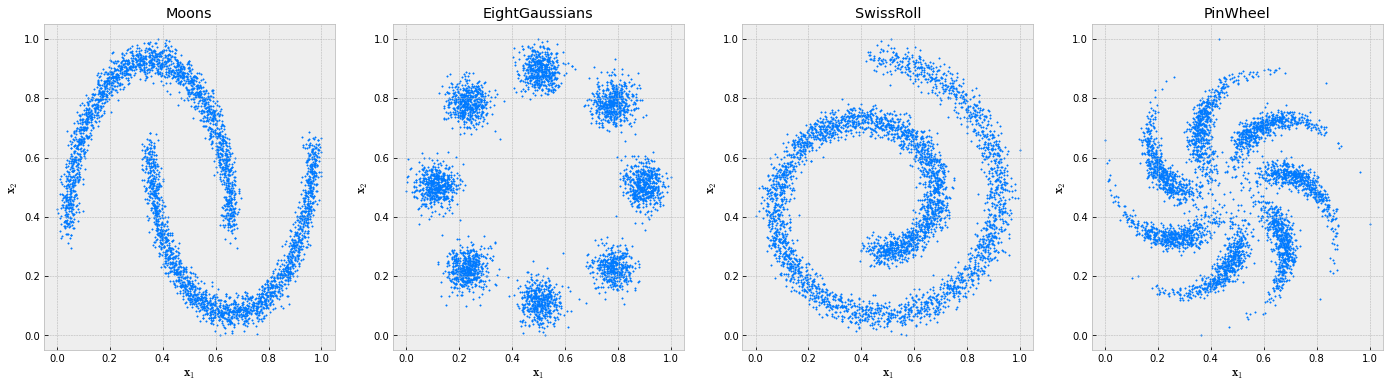

In [8]:
fig, axes = plt.subplots(1, len(names_dataset), figsize=(6 * len(names_dataset), 6),
                         gridspec_kw={'width_ratios': [1] * len(names_dataset)})

for i in range(len(names_dataset)):
    name = names_dataset[i]
    x = datasets[name]
    axes[i].scatter(x[:, 0], x[:, 1], c="#007aff", s=2)
    axes[i].set(title=f"{name}", xlabel="$\mathbf{x}_1$", ylabel="$\mathbf{x}_2$")
plt.savefig("datasets.png")
plt.show()

In [9]:
class RealNVPModel:
    def __init__(self, D, d, n_couple_layers, z_dist=None):
        """Init Model

        :param D: int - số chiều vectơ ngẫu nhiên x và z
        :param d: int - số chiều giữ nguyên trong RealNVP
        :param n_couple_layers: int - số layer đôi xen kẻ nhau (số layer = số layer đôi nhân 2)
        :param z_dist: tdf.Distribution - phân bố z, hoặc bất kì thư viện nào lấy log_prob.
                       Nếu không khai báo gì thêm sẽ lấy MultivariateNormalDiag
                       Lưu ý: không bất kì tham số nào z_dist là được học (cố định)
                       Do đó nếu như truyền vào phân bố từ tfp thì nhớ kiểm tra trainable_variables
                       Cheer!
        """
        if z_dist is None:
            z_dist = tfp.distributions.MultivariateNormalDiag(loc=[0.0]*D, scale_diag=[1.0]*D)
        
        self.z_distribution = z_dist
        self.n_layers = n_couple_layers * 2
        self.D = D
        self.d = d

        #  binary mask cho mỗi lớp layer
        self.binary_masks = np.array([
            [(i+1)%2]*d + [(i)%2]*(D-d)
            for i in range(self.n_layers)], dtype=np_dtype)
        
        # Hàm scale & translation tương ứng mỗi affine coupling layer
        self.scale_func_list = [self.__get_scale_function() 
                                for _ in range(self.n_layers)]
        self.translation_func_list = [self.__get_translation_function() 
                                      for _ in range(self.n_layers)]

    def __get_scale_function(self, l2=0.1):
        """Trả về scale function là neural network
        Thoải mái viết lại hàm này! Khi thấy cần tăng, giảm độ phức tạp.
        """
        assert self.D==2, "Viết lại hàm này nhé :D Tăng phức tạp lên tí nếu cần!"
        s_func = Sequential([Input(shape=self.D),
                             Dense(256, activation="relu", kernel_regularizer=regularizers.l2(l2)),
                             Dense(256, activation="relu", kernel_regularizer=regularizers.l2(l2)),
                             Dense(128, activation="tanh", kernel_regularizer=regularizers.l2(l2)),
                             Dense(self.D, activation="tanh", kernel_regularizer=regularizers.l2(l2))])
        return s_func

    def __get_translation_function(self, l2=0.1):
        """Trả về translation function là neural network
        Thoải mái viết lại hàm này! Khi thấy cần tăng, giảm độ phức tạp.
        """
        assert self.D==2, "Viết lại hàm này nhé :D Tăng phức tạp lên tí nếu cần!"
        t_func = Sequential([Input(shape=self.D),
                             Dense(256, activation="relu", kernel_regularizer=regularizers.l2(l2)),
                             Dense(256, activation="relu", kernel_regularizer=regularizers.l2(l2)),
                             Dense(128, activation="tanh", kernel_regularizer=regularizers.l2(l2)),
                             Dense(self.D, activation="linear", kernel_regularizer=regularizers.l2(l2))])
        return t_func

    def pdf_x(self, x):
        """Hàm mật độ xác suất p.d.f probability density function của x
        """
        z, log_det = self.map_from_x_to_z_with_logdet(x)
        pdf_z = self.z_distribution.prob(z)
        pdf_x = pdf_z * np.abs(np.exp(log_det))
        return pdf_x

    def pdf_z(self, z):
        """Hàm mật độ xác suất p.d.f probability density function của z
        """
        return self.z_distribution.prob(z)
    
    def map_from_x_to_z_with_logdet(self, x):
        """Biến đổi x -> z qua z=g^-1(x)

        :return z:
        :return log_det_inv:
        """
        log_det_inv = 0
        z_k = x

        for k in reversed(range(self.n_layers)):
            b = self.binary_masks[k]
            b_x = b * z_k

            s = self.scale_func_list[k]
            t = self.translation_func_list[k]

            z_k = b_x + (1-b) * (z_k * tf.math.exp(s(b_x)) + t(b_x))
            log_det_inv = log_det_inv + tf.reduce_sum((1-b)*s(b_x), axis=1)
        return z_k, log_det_inv

    def map_from_x_to_z(self, x):
        """Biến đổi x -> z qua z=g^-1(x)

        :return z:
        """
        z, _ = self.map_from_x_to_z_with_logdet(x)
        return z

    def map_from_z_to_x_with_logdet(self, z, k_layers=None):
        """Biến đổi z -> x qua x=g(z)

        :return x:
        :return log_det_inv:
        """
        log_det_inv = 0
        x_k = z

        list_layers = list(range(self.n_layers))
        if k_layers:
            list_layers = list_layers[:k_layers]
        
        for k in list_layers:
            b = self.binary_masks[k]

            b_z = b * x_k

            s = self.scale_func_list[k]
            t = self.translation_func_list[k]

            x_k = b_z + (1-b) * (x_k - t(b_z)) * tf.math.exp(-s(b_z))
            log_det_inv = log_det_inv - tf.reduce_sum((1-b)*s(b_z), axis=1)
        return x_k, log_det_inv

    def map_from_z_to_x(self, z):
        """Biến đổi z -> x qua x=g(z)

        :return x:
        """
        x, _ = self.map_from_z_to_x_with_logdet(z)
        return x

    def sampling_z(self, n_samples):
        """Lấy mẫu z
        """
        return self.z_distribution.sample(n_samples).numpy()

    def sampling_x(self, n_samples):
        """Lấy mẫu x
        """
        z = self.sampling_z(n_samples)
        x = self.map_from_z_to_x(z)
        return x

    
def negative_log_likelihood(x, model):
    """Hàm âm log hợp lý (negative log likelihood)
    """
    z, logdet = model.map_from_x_to_z_with_logdet(x)
    log_likelihood = model.z_distribution.log_prob(z) + logdet
    nll = -tf.reduce_sum(log_likelihood)
    return nll

In [10]:
def train_real_nvp_model(dataset, test_size, batch_size, n_epochs, verbose=False):
    """Huấn luyện mô hình

    :param dataset: tập dữ liệu X gồm D cột và n hàng
    :param test_size: tỉ lệ validation
    :param batch_size: batch_size huấn luyện
    :param n_epochs: số bước tối ưu
    :param verbose: có in ra dài dòng lê thê kooooo
    """
    x_train, x_val = train_test_split(dataset, test_size=test_size)
    n_train_samples = len(x_train)
    n_validation_samples = len(x_val)

    train_dataset = tf.data.Dataset.from_tensor_slices(x_train)\
        .shuffle(len(x_train)).batch(batch_size)
    validation_dataset = tf.data.Dataset.from_tensor_slices(x_val)\
        .shuffle(len(x_val)).batch(batch_size)

    # Thiết lập thuật toán tối ưu
    optimizer = optimizers.Adam(learning_rate=1e-3)

    # Tùy chỉnh model, bạn có thể tăng, giảm độ phức tạp n_couple_layers tùy muốn
    model = RealNVPModel(D=2, d=1, n_couple_layers=3)

    # Biên dịch sang callable TensorFlow graph với tf.function chạy nhanh hơn
    @tf.function
    def train_step(x_batch_train):
        with tf.GradientTape() as tape:
            loss_value = negative_log_likelihood(x_batch_train, model)

        variables = tape.watched_variables()
        gradients = tape.gradient(loss_value, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        return loss_value

    @tf.function
    def test_step(x_batch_validation):
        loss_value = negative_log_likelihood(x_batch_validation, model)
        return loss_value

    loss_train = []
    loss_validation = []

    for epoch in tqdm.tqdm(range(n_epochs)):
        train_nll = 0
        validation_nll = 0
        for step, x_batch_train in enumerate(train_dataset):
            train_nll += train_step(x_batch_train)
        for x_batch_validation in validation_dataset:
            validation_nll += test_step(x_batch_validation)

        # tính nll cho per sample để dể quan sát so sánh
        train_nll_per_sample = train_nll / n_train_samples
        validation_nll_per_sample = validation_nll / n_validation_samples
        
        loss_train.append(train_nll_per_sample)
        loss_validation.append(validation_nll_per_sample)

        if verbose:
            tqdm.tqdm.write(
                f"[{str(epoch).zfill(4)}] " + 
                f"train loss {'{:.6f}'.format(train_nll_per_sample)} " +
                f"val loss {'{:.6f}'.format(validation_nll_per_sample)}")

    return model, loss_train, loss_validation

In [11]:
dict_model = {}

for i in range(len(datasets)):
    name = names_dataset[i]
    dataset = datasets[name]
    model, loss_train, loss_validation = train_real_nvp_model(dataset, test_size=0.25, batch_size=128, n_epochs=300, verbose=False)
    dict_model[name] = model, loss_train, loss_validation

100%|██████████| 300/300 [01:22<00:00,  3.66it/s]


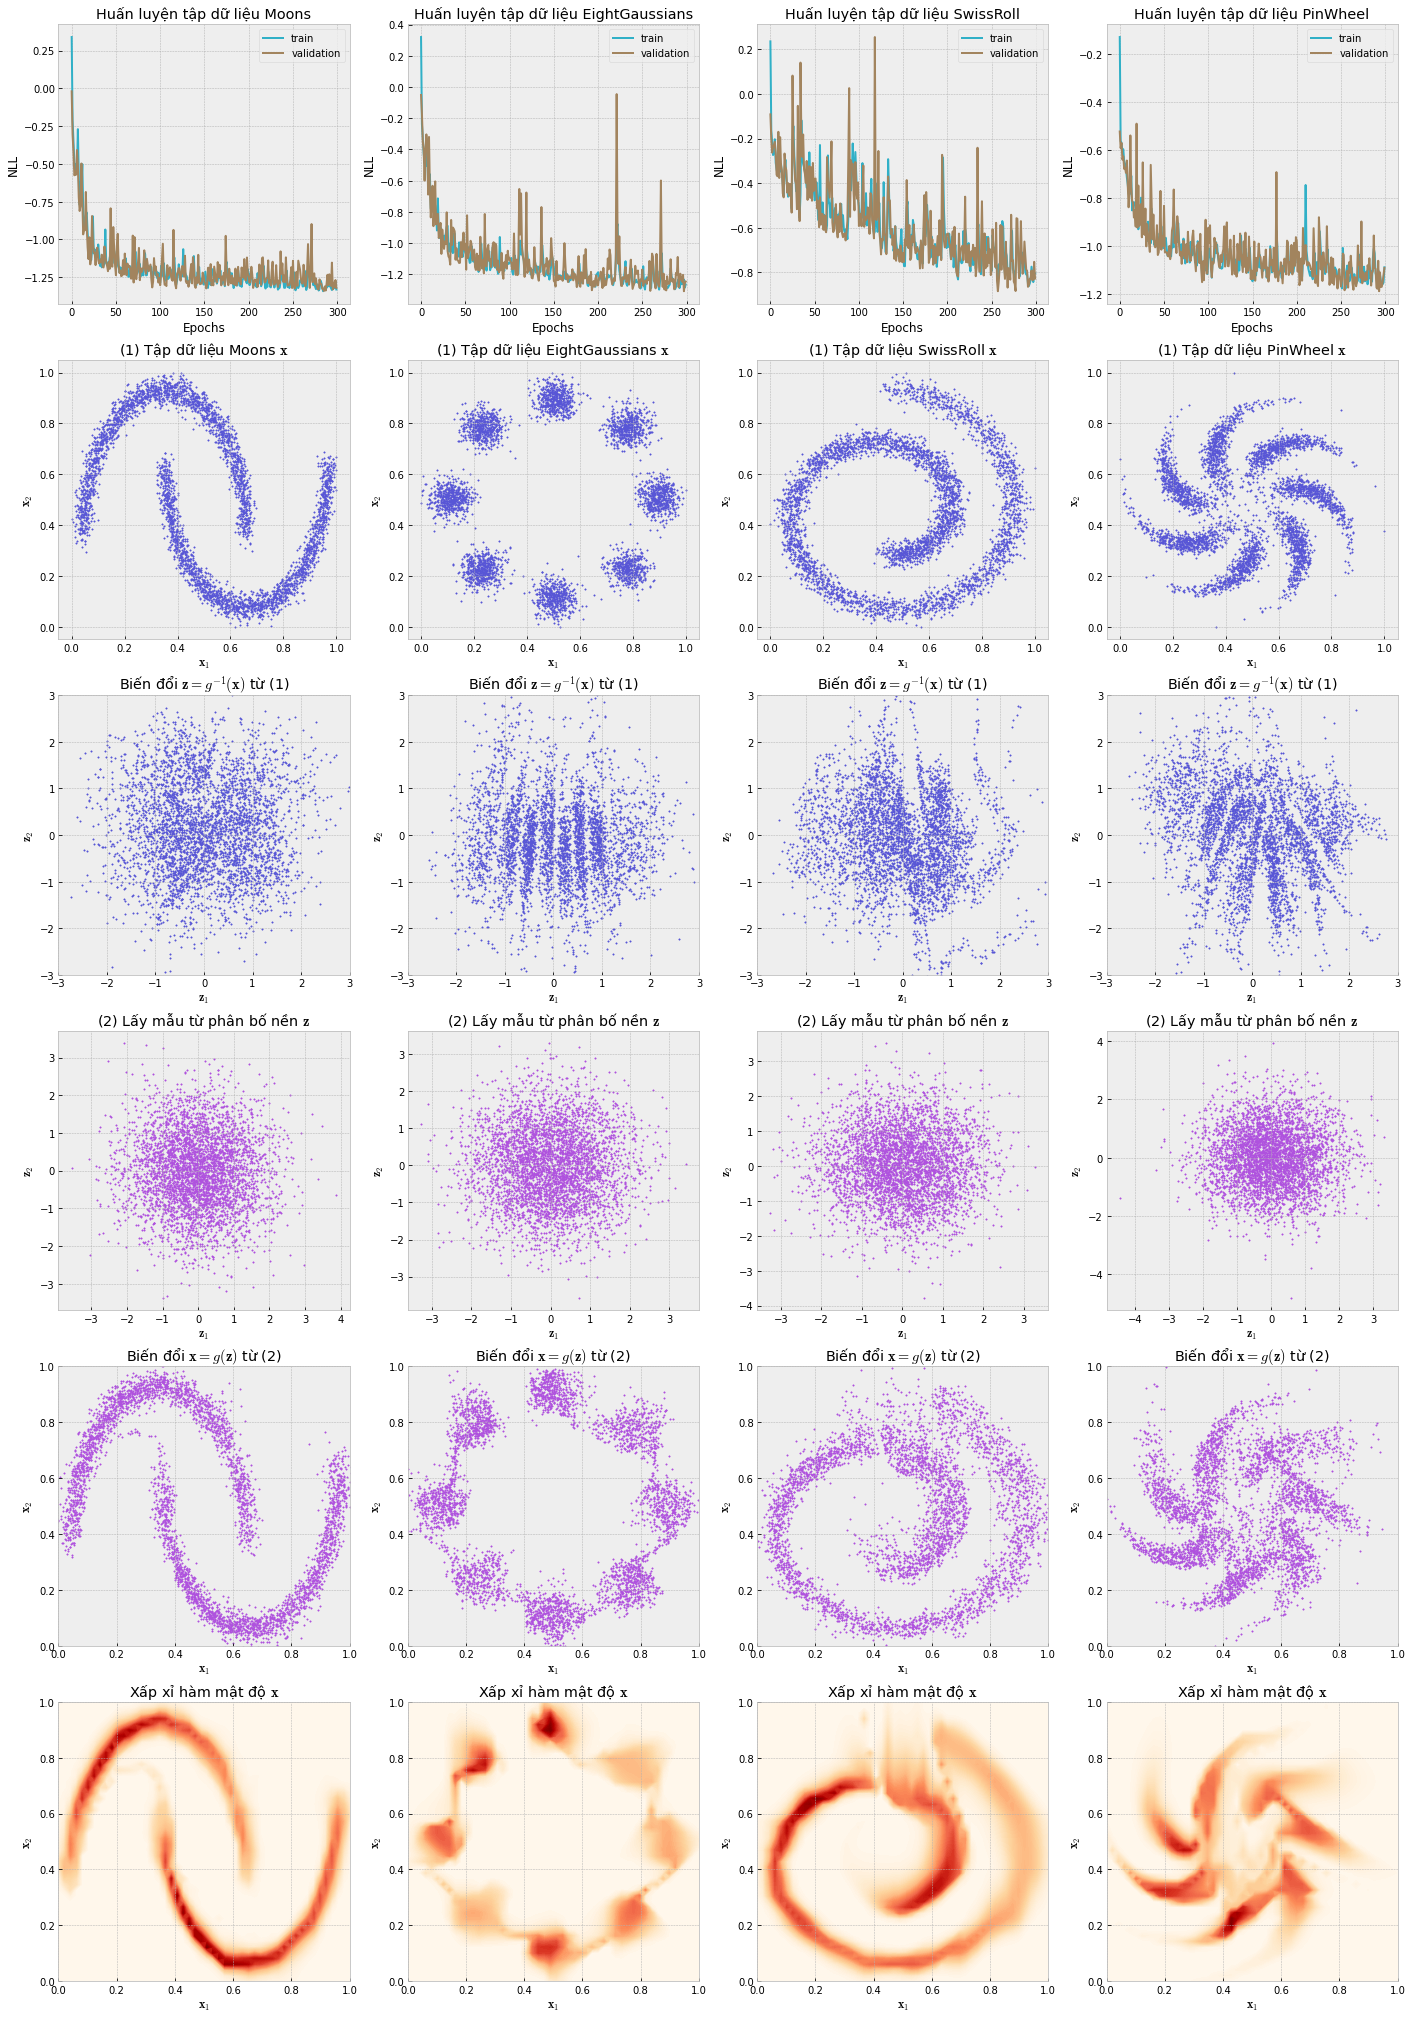

In [12]:
def visualize_for_dataset(name, axes, idx_axes, model, loss_train, loss_validation):
    """Trực quan hóa dành cho ax tương ứng
    """
    x_dataset = datasets[name]
    axes[0, idx_axes].plot(loss_train, color="#30b0c7")
    axes[0, idx_axes].plot(loss_validation, color="#a2845e")
    axes[0, idx_axes].set(title=f"Huấn luyện tập dữ liệu {name}", xlabel="Epochs", ylabel="NLL")
    axes[0, idx_axes].legend(["train", "validation"], loc="upper right")

    # Biến đỗi x->z từ tập dữ liệu
    z_dataset = model.map_from_x_to_z(x_dataset)
    axes[1, idx_axes].scatter(x_dataset[:, 0], x_dataset[:, 1], color="#5856d6", s=2)
    axes[1, idx_axes].set(title="(1) Tập dữ liệu "+name+" $\mathbf{x}$", xlabel="$\mathbf{x}_1$", ylabel="$\mathbf{x}_2$")
    axes[2, idx_axes].scatter(z_dataset[:, 0], z_dataset[:, 1], color="#5856d6", s=2)
    axes[2, idx_axes].set(title="Biến đổi $\mathbf{z}=g^{-1}(\mathbf{x})$ từ (1)", xlabel="$\mathbf{z}_1$", ylabel="$\mathbf{z}_2$")
    axes[2, idx_axes].set_xlim([-3, 3])
    axes[2, idx_axes].set_ylim([-3, 3])

    # Lấy mẫu z từ phân bố nền (base distribution)
    z_samples = model.sampling_z(len(x_dataset))
    # Biến đổi từ z->x
    x_samples = model.map_from_z_to_x(z_samples)
    axes[3, idx_axes].scatter(z_samples[:, 0], z_samples[:, 1], color="#af52de", s=2)
    axes[3, idx_axes].set(title="(2) Lấy mẫu từ phân bố nền $\mathbf{z}$", xlabel="$\mathbf{z}_1$", ylabel="$\mathbf{z}_2$")
    axes[4, idx_axes].scatter(x_samples[:, 0], x_samples[:, 1], color="#af52de", s=2)
    axes[4, idx_axes].set(title="Biến đổi $\mathbf{x}=g(\mathbf{z})$ từ (2)", xlabel="$\mathbf{x}_1$", ylabel="$\mathbf{x}_2$")
    axes[4, idx_axes].set_xlim([0, 1])
    axes[4, idx_axes].set_ylim([0, 1])

    # Vẽ countour map
    n_point = 50 # số điểm neo
    min_x = 0
    max_x = 1
    x0_lin = np.linspace(min_x, max_x, n_point)
    x1_lin = np.linspace(min_x, max_x, n_point)

    x0_grid, x1_grid = np.meshgrid(x0_lin, x1_lin)

    x_contour = np.hstack([x0_grid.reshape(n_point ** 2, 1),
                           x1_grid.reshape(n_point ** 2, 1)])
    z_contour = model.pdf_x(x_contour).numpy().reshape(n_point, n_point)
    axes[5, idx_axes].contourf(x0_grid, x1_grid, z_contour, cmap="OrRd", levels=100)
    axes[5, idx_axes].set_xlim([0, 1])
    axes[5, idx_axes].set_ylim([0, 1])
    axes[5, idx_axes].set(title="Xấp xỉ hàm mật độ $\mathbf{x}$", xlabel="$\mathbf{x}_1$", ylabel="$\mathbf{x}_2$")

fig, axes = plt.subplots(6, len(names_dataset), figsize=(6*len(names_dataset), 6*6),
                             gridspec_kw={'width_ratios': [1]*len(names_dataset)})

for i in range(len(datasets)):
    name = names_dataset[i]
    model, loss_train, loss_validation = dict_model[name]
    visualize_for_dataset(name, axes, i, model, loss_train, loss_validation)

plt.savefig("train.jpg")
plt.savefig("train.png")
plt.show()

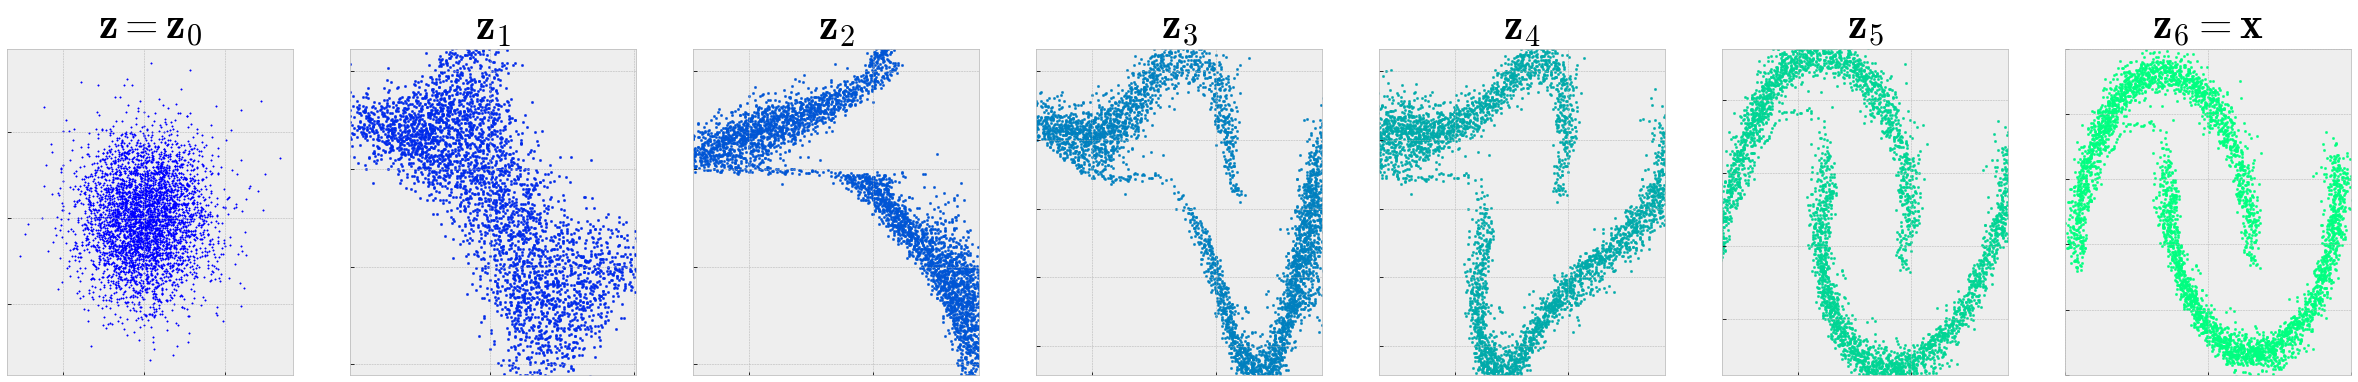

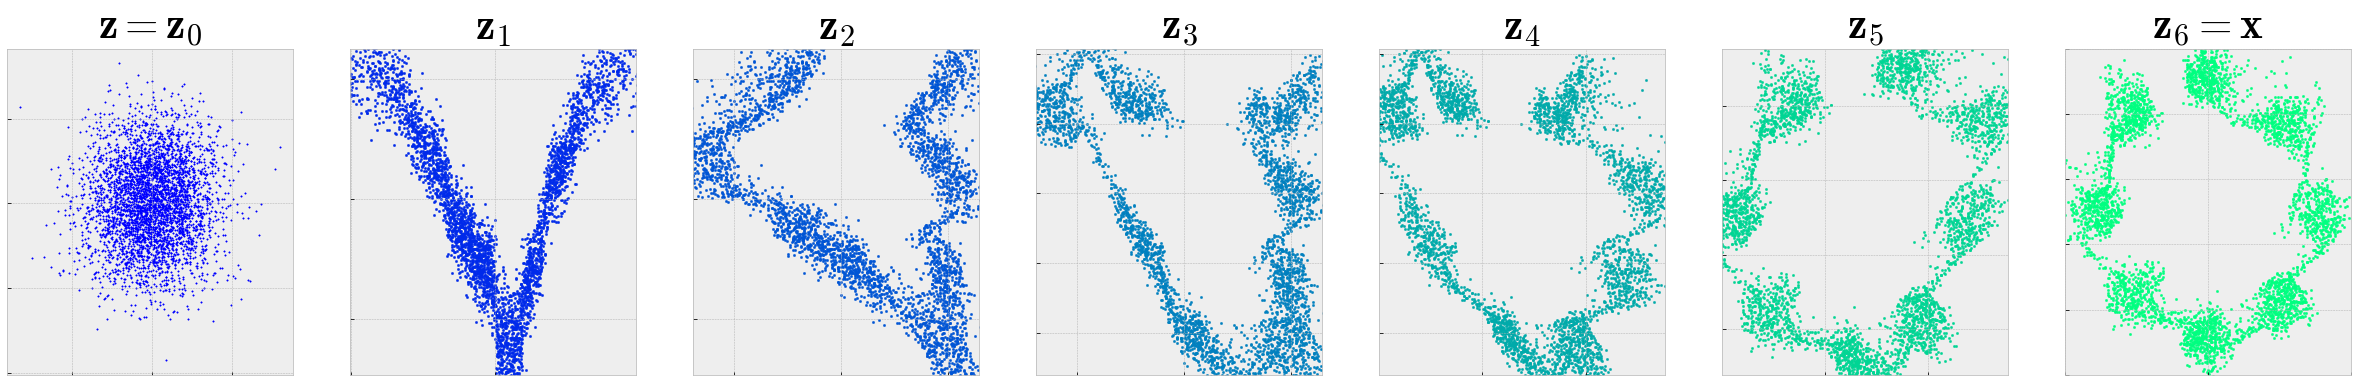

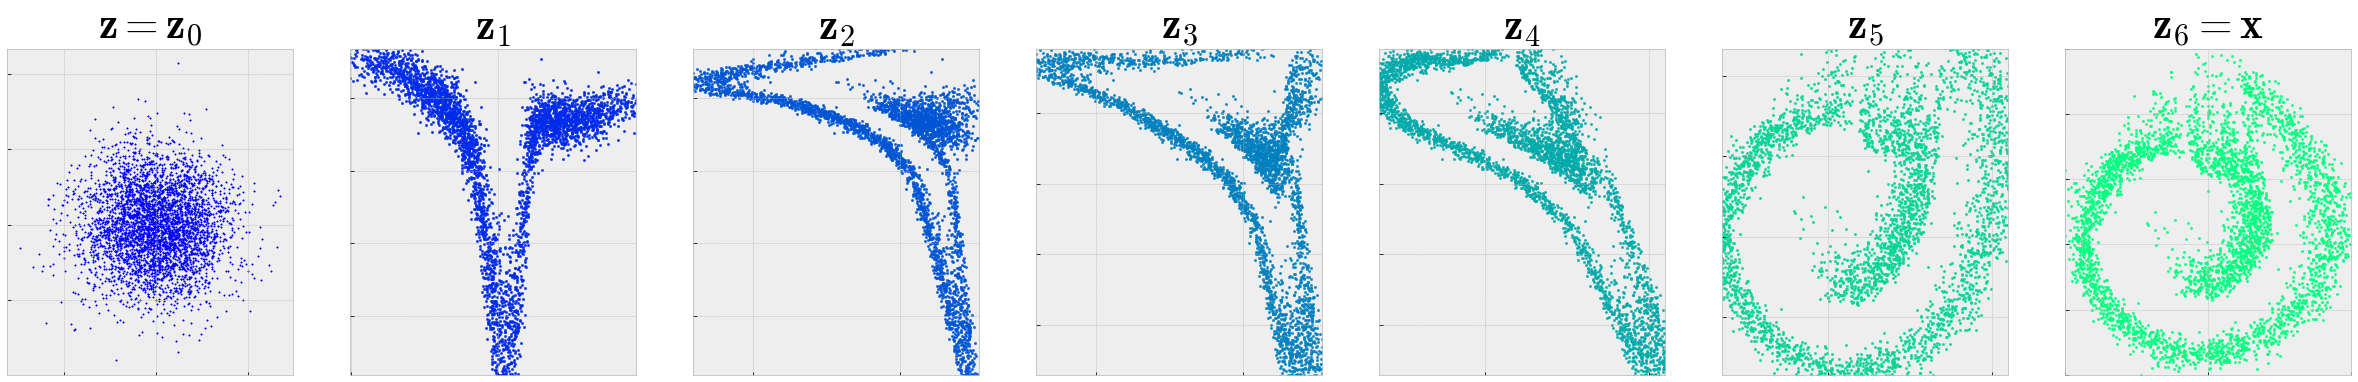

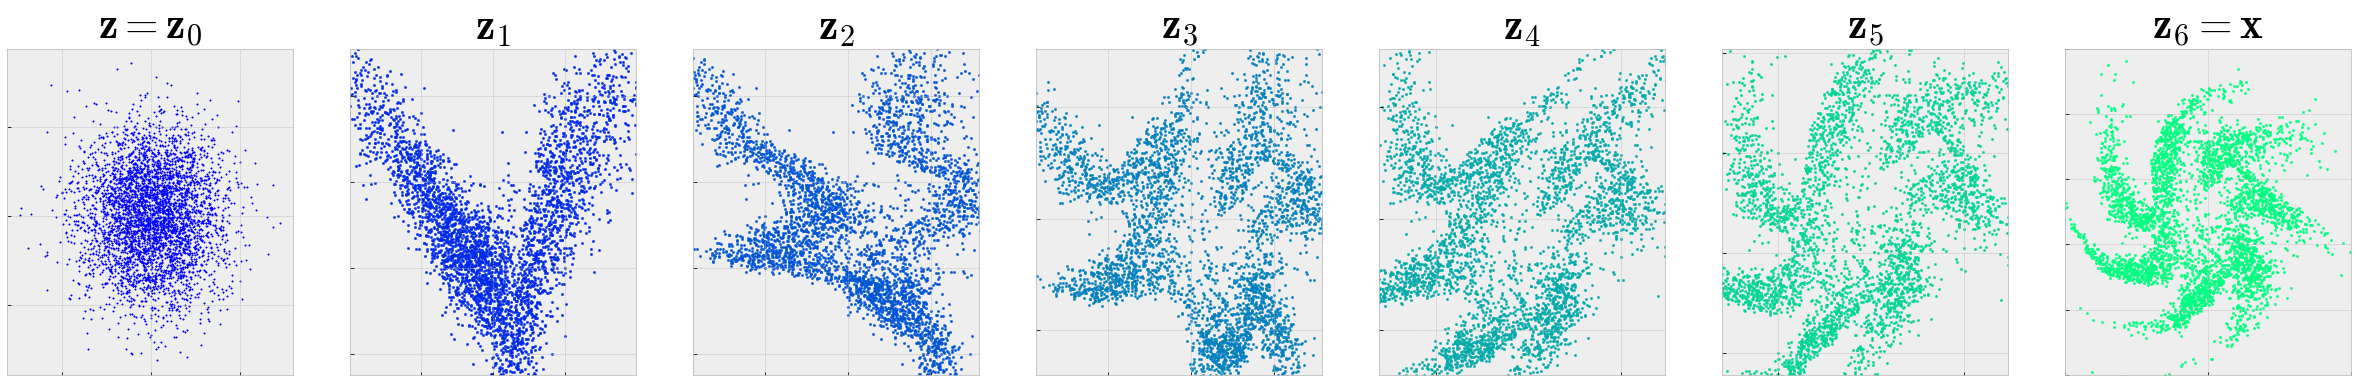

In [13]:
plt.rcParams.update({'font.size': 30})
for name in names_dataset:
    model, _, _ = dict_model[name]
    cmap = cm.get_cmap('winter')
    n_layers = model.n_layers
    fig, axes = plt.subplots(1, n_layers+1, figsize=(6*(n_layers+1), 6*1),
                                    gridspec_kw={'width_ratios': [1]*(n_layers+1)})
    z_samples_flows = model.sampling_z(4048)
    for k in range(1, 7):
        x_i, _ = model.map_from_z_to_x_with_logdet(z_samples_flows, k)
        x0_percentile05 = np.percentile(x_i[:,0], 2.5)
        x0_percentile95 = np.percentile(x_i[:,0], 97.5)
        x1_percentile05 = np.percentile(x_i[:,1], 2.5)
        x1_percentile95 = np.percentile(x_i[:,1], 97.5)
        axes[k].scatter(x_i[:,0], x_i[:, 1], s=5, color=cmap(k/6))
        axes[k].set(title="$\mathbf{z}"+f"_{k}$")
        axes[k].axes.xaxis.set_ticklabels([])
        axes[k].axes.yaxis.set_ticklabels([])
        axes[k].set_xlim([x0_percentile05, x0_percentile95])
        axes[k].set_ylim([x1_percentile05, x1_percentile95])

    axes[0].scatter(z_samples_flows[:,0], z_samples_flows[:, 1], s=2, color=cmap(0))
    axes[0].set(title="$\mathbf{z}=\mathbf{z}_0$")
    axes[0].axes.xaxis.set_ticklabels([])
    axes[0].axes.yaxis.set_ticklabels([])
    axes[n_layers].set(title="$\mathbf{z}_6=\mathbf{x}$")
    axes[n_layers].set_xlim([0, 1])
    axes[n_layers].set_ylim([0, 1])

    plt.show()